## This notebook calls the merger function

In [1]:
import numpy as np
from scipy.interpolate import interp1d
from astropy.cosmology import Planck15 as cosmo
from astropy.cosmology import z_at_value
from astropy import units as u
import sfh
import mergers as m

import matplotlib.pyplot as plt

In [2]:
metallicities = ['0.000085', '0.00012673', '0.00018896', '0.00028173', '0.00042005',
                 '0.00062629', '0.00093378', '0.00139224', '0.00207579', '0.00309496',
                 '0.00461451', '0.00688012', '0.0102581', '0.01529458', '0.02280385', '0.034']
mets = [0.00008500, 0.00012673, 0.00018896, 0.00028173, 0.00042005,
        0.00062629, 0.00093378, 0.00139224, 0.00207579, 0.00309496,
        0.00461451, 0.00688012, 0.01025810, 0.01529458, 0.02280385, 0.03400000]

## Set up interpolator to go between redshift and lookback time
t_merge_list = np.linspace(1e-3, 13700, 500)

z_merge_list = []
for t in t_merge_list:
    z_merge_list.append(z_at_value(cosmo.lookback_time, t * u.Myr))

z_interp = interp1d(t_merge_list, z_merge_list)



In [3]:
# set up a linspace of redshift bins:
zbins_100 = np.linspace(0, 15, 100)

# set up metallicity weights for the star formation history
met_weights_100 = sfh.get_metallicity_weights(zbins_100, mets)

# set up differential comoving volume
dVdz_100 = cosmo.differential_comoving_volume(zbins_100).to(u.Gpc**(3)*u.steradian**(-1)).value*(4*np.pi)

In [4]:
# set up a linspace of redshift bins:
zbins_50 = np.linspace(0, 15, 50)

# set up metallicity weights for the star formation history
met_weights_50 = sfh.get_metallicity_weights(zbins_50, mets)

# set up differential comoving volume
dVdz_50 = cosmo.differential_comoving_volume(zbins_50).to(u.Gpc**(3)*u.steradian**(-1)).value*(4*np.pi)

In [5]:
# get mergers for each alpha
mergers_100 = m.get_mergers(zbins_100, mets, metallicities, alpha=1, z_interp=z_interp, downsample=50)
mergers_100['z_digits'] = np.digitize(mergers_100['z_merge'], zbins_100)

100%|██████████| 16/16 [00:34<00:00,  2.13s/it]


In [6]:
mergers_50 = m.get_mergers(zbins_50, mets, metallicities, alpha=1, z_interp=z_interp, downsample=50)
mergers_50['z_digits'] = np.digitize(mergers_50['z_merge'], zbins_50)

100%|██████████| 16/16 [00:14<00:00,  1.11it/s]


## From these mergers we can calculate the comoving merger rate in the detector frame

In [7]:
comoving_rate_100 = mergers_100.groupby('z_digits').sum().reset_index()
comoving_rate_50 = mergers_50.groupby('z_digits').sum().reset_index()

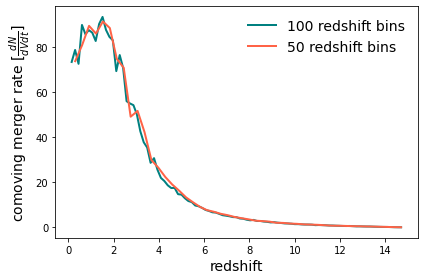

In [8]:
plt.plot(zbins_100[comoving_rate_100['z_digits']], comoving_rate_100['dN_dVdtm_det'], lw=2, label='100 redshift bins', color='teal')
plt.plot(zbins_50[comoving_rate_50['z_digits']], comoving_rate_50['dN_dVdtm_det'], lw=2, label='50 redshift bins', color='tomato')
plt.xlabel('redshift', size=14)
plt.ylabel(r'comoving merger rate [$\frac{dN}{dVdt}$]', size=14)
plt.legend(prop={'size':14}, frameon=False)
plt.tight_layout()

## We can also calculate the cumulative volumetric rate as a function of redshift

In [9]:
delta_z_50 = zbins_50[1] - zbins_50[0]
delta_z_100 = zbins_100[1] - zbins_100[0]


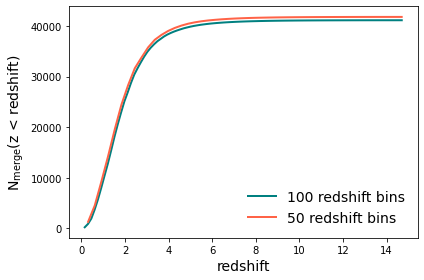

In [10]:
plt.plot(zbins_100[comoving_rate_100['z_digits']], 
         np.cumsum(comoving_rate_100['dN_dVdtm_det']*dVdz_100[comoving_rate_100['z_digits']] * 1/(1+zbins_100[comoving_rate_100['z_digits']]))*delta_z_100, 
         lw=2, label='100 redshift bins', color='teal')
plt.plot(zbins_50[comoving_rate_50['z_digits']], 
         np.cumsum(comoving_rate_50['dN_dVdtm_det']*dVdz_50[comoving_rate_50['z_digits']] * 1/(1+zbins_50[comoving_rate_50['z_digits']]))*delta_z_50, 
         lw=2, label='50 redshift bins', color='tomato')

plt.xlabel('redshift', size=14)
plt.ylabel(r'N$_{\rm{merge}}$(z < redshift)', size=14)
plt.legend(prop={'size':14}, frameon=False)
plt.tight_layout()